<a href="https://colab.research.google.com/github/fgith/data-science/blob/main/kaggle/heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [35]:
! wget "https://raw.githubusercontent.com/fgith/data-science/main/datasets/healthcare-dataset-stroke-data.csv"

--2022-05-19 15:49:51--  https://raw.githubusercontent.com/fgith/data-science/main/datasets/healthcare-dataset-stroke-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 316971 (310K) [text/plain]
Saving to: ‘healthcare-dataset-stroke-data.csv.1’

healthcare-dataset- 100%[===================>] 309.54K  --.-KB/s    in 0.01s   

2022-05-19 15:49:51 (23.9 MB/s) - ‘healthcare-dataset-stroke-data.csv.1’ saved [316971/316971]



# **1. Load Data**

In [36]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# **2. Explore Data**

In [37]:
print('----------Dataset Shape----------')
print('No of Rows: ', df.shape[0],'| No of Columns: ',df.shape[1])
print('Columns:', df.columns.tolist())
print('---------------------------------')
print('----Column-wise unique values----')
cols = ['gender','hypertension','ever_married','work_type','Residence_type','smoking_status','stroke','heart_disease']
for i in range(len(cols)):
  print(cols[i],": ",df[cols[i]].unique().tolist())
print('---------------------------------')
print('-----Column-wise Nulls Dtype-----')
print(df.info())
print('---------------------------------')
print("No of Null values in column \'bmi':",df.bmi.isna().sum())

----------Dataset Shape----------
No of Rows:  5110 | No of Columns:  12
Columns: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
---------------------------------
----Column-wise unique values----
gender :  ['Male', 'Female', 'Other']
hypertension :  [0, 1]
ever_married :  ['Yes', 'No']
work_type :  ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']
Residence_type :  ['Urban', 'Rural']
smoking_status :  ['formerly smoked', 'never smoked', 'smokes', 'Unknown']
stroke :  [1, 0]
heart_disease :  [1, 0]
---------------------------------
-----Column-wise Nulls Dtype-----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   objec

**Observations:**
* Column 'bmi' has 201 Null values. These need to be transformed into numerical values later in the code
* Columns 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status' have Dtype Object/String. These need to be transformed into numerical values later in the code

**Let's do the following:**
*   Drop un-needed column 'id'

In [38]:
df.drop('id', axis=1, inplace = True)
df = df.reset_index(drop = True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df.

# **3. Data Preprocessing**

In [7]:
df.fillna(0, inplace=True)
X = df.drop(['stroke','gender','ever_married','work_type','Residence_type','smoking_status'],axis=1)
# X = df.drop(['stroke'],axis=1)
y = df['stroke'].to_frame()

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state=0)

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score

In [29]:
rnd_clf = RandomForestClassifier(n_estimators=20)
log_clf = LogisticRegression()
svc_clf = SVC(probability=True)

0.9527886497064579


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


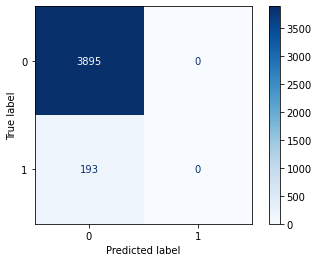

In [30]:
voting_clf = VotingClassifier(estimators = [('lr',log_clf),('rf',rnd_clf),('svc',svc_clf)],voting='hard')
voting_clf.fit(X_train,np.ravel(y_train))
y_pred = voting_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
cross_val_score(voting_clf, X_train, np.ravel(y_train)).mean() # Cross val score
plot_confusion_matrix(voting_clf, X_test, y_test, cmap = 'Blues', values_format = 'd')

In [31]:
params = { 'voting' : ['hard','soft'],
          'weights' : [(1,1,2),(2,1,1),(1,2,1)]
}
grid = GridSearchCV(voting_clf, params)
grid.fit(X_train, np.ravel(y_train))
grid.best_params_

{'voting': 'hard', 'weights': (1, 1, 2)}

In [32]:
grid.best_score_

0.9452080344332856

In [33]:
from sklearn.metrics import accuracy_score

for clf in (log_clf,rnd_clf,svc_clf,voting_clf):
  clf.fit(X_train,np.ravel(y_train))
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__,accuracy_score(y_test,y_pred))

LogisticRegression 0.9525440313111546
RandomForestClassifier 0.9488747553816047
SVC 0.9527886497064579
VotingClassifier 0.9527886497064579


In [13]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=20)
rf_clf.fit(X_train, y_train)
rf_clf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


array([0, 0, 0, ..., 0, 0, 0])

In [14]:
y_pred = rf_clf.predict(X_test)

[[3895    0]
 [ 193    0]]
0.9527886497064579


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


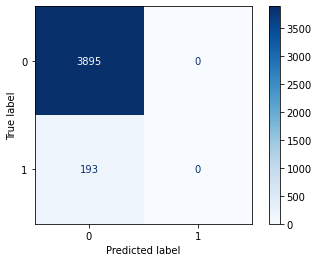

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
plot_confusion_matrix(voting_clf, X_test, y_test, cmap = 'Blues', values_format = 'd')